In [1]:
import torch
from math import pi,sqrt,log,e,exp
from time import time
from matplotlib import pyplot
import numpy as np
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
#dtype = torch.float
device = torch.device("cuda:7")
#torch.set_default_dtype(torch.float64)

#torch.autograd.set_detect_anomaly(True)

from src.training.weighted_dataset.dkl_training import BasicStatefulDKLTrainer
from src.training.weighted_dataset.variance_training import BasicStatefulVarTrainer
from src.models.flows.sequential import InvertibleSequentialFlow
from src.models.flows.coupling_cells.real_nvp import RealNVP
from src.models.flows.coupling_cells.piecewise_coupling.piecewise_linear import PWLinearCoupling
from src.models.flows.sampling import UniformSampler,FactorizedGaussianSampler
from src.models.flows.analytic_flows.element_wise import InvertibleAnalyticSigmoid
from src.integration.flat_survey_integrator import FlatSurveySamplingIntegrator
from src.integration.dkltrainer_integrator import DKLAdaptiveSurveyIntegrator
from src import setup_std_stream_logger

In [2]:
setup_std_stream_logger(debug=True)

In [3]:
posterior=UniformSampler(d=2,low=0.,high=1.,device=device)
prior=UniformSampler(d=2,low=0.,high=1.,device=device)
prior2=FactorizedGaussianSampler(d=2,device=device)

In [4]:
def one(x):
    return torch.ones(x.shape[0],device=x.device)

def nonzerocos(x):
    return torch.cos(4*(x[:,0]+x[:,1]))**2

def twogauss(x):
    return 1+10*torch.exp(- torch.sum(((x-.25)/0.1)**2,dim=-1)  )+10*torch.exp(- torch.sum(((x-.75)/0.1)**2,dim=-1)  )

def circle(x):
    
    return torch.exp( - ((torch.sqrt(torch.sum((x-.5)**2,dim=-1)) - 0.3)/0.3)**2 )

f = nonzerocos 

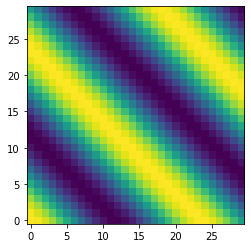

In [5]:
n = 30
plt.imshow(f(torch.cartesian_prod(torch.arange(0,1,1/n),torch.arange(0,1,1/n))).reshape(n,n).numpy(),origin="lower")
plt.show()

In [6]:
class Reshift(torch.nn.Module):
    def forward(self,x):
        return (x-0.5)*2.
    
class Sine(torch.nn.Module):
    def __init__(self, w0 = 1.):
        super().__init__()
        self.w0 = w0
    def forward(self, x):
        return torch.sin(self.w0 * x)
    
try:
    del model
except:
    pass

model  = InvertibleSequentialFlow(2,[
        PWLinearCoupling(d=2,
              mask=[True,False],
              d_hidden=32,
              n_hidden=4,
              n_bins=10,
              hidden_activation=torch.nn.LeakyReLU,
              input_activation=Reshift,
              use_batch_norm=False).to(device),
        PWLinearCoupling(d=2,
              mask=[False,True],
              d_hidden=32,
              n_hidden=4,
              n_bins=10,
              hidden_activation=torch.nn.LeakyReLU,
              input_activation=Reshift,
              use_batch_norm=False).to(device),
])

# model2 = InvertibleSequentialFlow(2,
#                                 [
#                                     RealNVP(d=2,
#                                     mask=[False,True],
#                                     d_hidden=512,
#                                     n_hidden=8
#                                     ).to(device),
                                    
#                                    RealNVP(d=2,
#                                     mask=[True,False],
#                                     d_hidden=512,
#                                     n_hidden=8
#                                     ).to(device),
#                                     RealNVP(d=2,
#                                     mask=[False,True],
#                                     d_hidden=512,
#                                     n_hidden=8
#                                     ).to(device),
                                    
#                                    RealNVP(d=2,
#                                     mask=[True,False],
#                                     d_hidden=512,
#                                     n_hidden=8
#                                     ).to(device),                                    
                                    
#                                     InvertibleAnalyticSigmoid(d=2).to(device)
#                                 ])


optim = torch.optim.Adam(model.parameters(),lr=1.e-3)


In [7]:
trainer = BasicStatefulDKLTrainer(flow=model,latent_prior=prior)

trainer.set_config(n_epochs=30, minibatch_size=20000, optim=optim)

integrator=DKLAdaptiveSurveyIntegrator(f,trainer,2,device=device, verbosity=3, trainer_verbosity=3)

result=integrator.integrate(2,1)

Starting integration
Initializing the survey phase
Starting the survey phase
Training on batch: 100000 points
Epoch 1/30
Loss: 9.569e-03
Loss: 9.127e-03
Loss: 7.900e-03
Loss: 7.257e-03
Loss: 6.637e-03
Epoch 2/30
Loss: 5.555e-03
Loss: 5.099e-03
Loss: 4.341e-03
Loss: 3.604e-03
Loss: 3.312e-03
Epoch 3/30
Loss: 2.486e-03
Loss: 1.977e-03
Loss: 1.507e-03
Loss: 6.568e-04
Loss: 5.375e-04
Epoch 4/30
Loss: -1.643e-04
Loss: -7.907e-04
Loss: -1.077e-03
Loss: -2.111e-03
Loss: -2.111e-03
Epoch 5/30
Loss: -2.743e-03
Loss: -3.493e-03
Loss: -3.688e-03
Loss: -4.894e-03
Loss: -4.888e-03
Epoch 6/30
Loss: -5.506e-03
Loss: -6.438e-03
Loss: -6.654e-03
Loss: -8.080e-03
Loss: -8.157e-03
Epoch 7/30
Loss: -8.781e-03
Loss: -9.959e-03
Loss: -1.027e-02
Loss: -1.204e-02
Loss: -1.225e-02
Epoch 8/30
Loss: -1.298e-02
Loss: -1.451e-02
Loss: -1.488e-02
Loss: -1.712e-02
Loss: -1.742e-02
Epoch 9/30
Loss: -1.834e-02
Loss: -2.032e-02
Loss: -2.072e-02
Loss: -2.347e-02
Loss: -2.391e-02
Epoch 10/30
Loss: -2.509e-02
Loss: -2.760

In [8]:
model.inverse

False

In [9]:
xj = prior(100)
yj = model(xj)
xj=xj.detach().cpu().numpy()
yj=yj.detach().cpu().numpy()

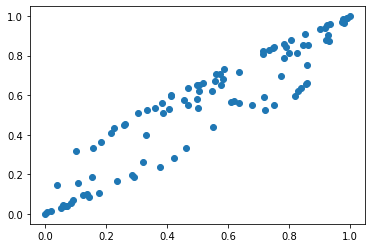

In [10]:
plt.scatter(xj[:,1],yj[:,1])

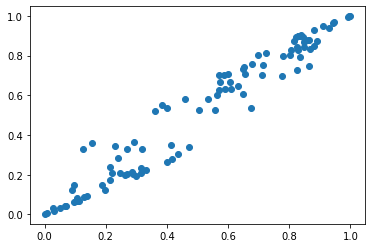

In [11]:
plt.scatter(xj[:,0],yj[:,0])

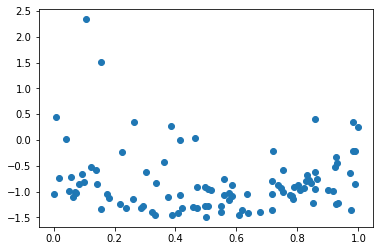

In [12]:
plt.scatter(xj[:,1],yj[:,2])

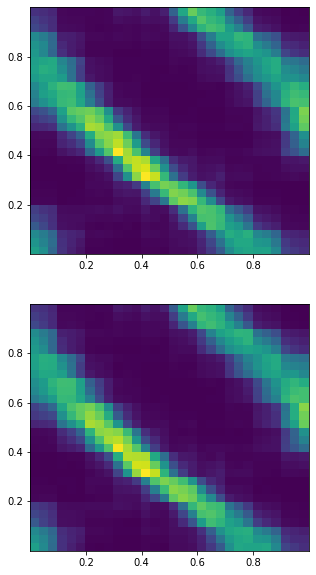

In [13]:
fig, axs = plt.subplots(2,1)
fig.set_size_inches(5,10)
for i in range(len(axs)):
    with torch.no_grad():
        xj = prior(1000000)
        yj = model(xj)
        xj=xj.detach().cpu().numpy()
        yj=yj.detach().cpu().numpy()
        h=axs[i].hist2d(yj[:,0],yj[:,1],bins=30)
 
plt.show()

In [44]:
distrib=h[0]/np.sum(h[0])

n=30
ftab=f(torch.cartesian_prod(torch.arange(0,1,1/n),torch.arange(0,1,1/n))).reshape(n,n).numpy()
ftabnorm=ftab/np.sum(ftab)

In [45]:
print((distrib/ftabnorm).min())
print((distrib/ftabnorm).max())
print((distrib/ftabnorm).mean())
print((distrib/ftabnorm).std())

0.0
155.31238413782708
1.6668913651291783
7.863775441580369


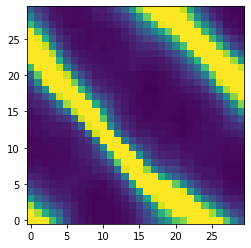

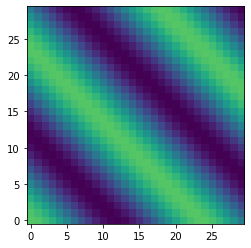

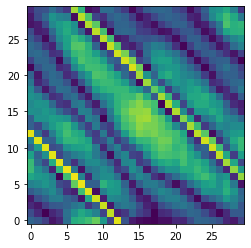

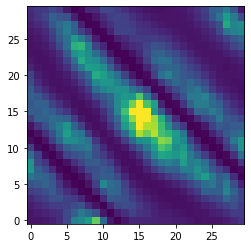

In [19]:
plt.imshow(distrib,interpolation=None,origin="lower",vmin=0.,vmax=3.e-3)
plt.show()
plt.imshow(ftabnorm,interpolation=None,origin="lower",vmin=0.,vmax=3.e-3)
plt.show()
fig,ax = plt.subplots()
plt.imshow(np.abs(ftabnorm-distrib)/(ftabnorm+distrib),interpolation=None,origin="lower",vmin=0.,vmax=1)
plt.show()
plt.imshow(ftabnorm/distrib,interpolation=None,origin="lower",vmin=0,vmax=10)
plt.show()

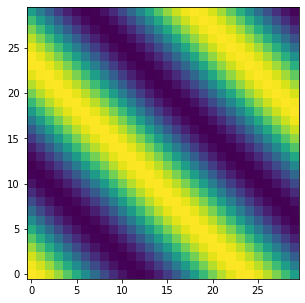

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
n=30
plt.imshow(f(torch.cartesian_prod(torch.arange(0,1,1/n),torch.arange(0,1,1/n))).reshape(n,n).numpy(),interpolation=None,origin="lower")
plt.show()

In [14]:
del xj,yj

In [15]:
xj = torch.arange(0.01,0.99,0.01)
xj=torch.stack((torch.ones_like(xj)/2.,xj,torch.zeros_like(xj)),-1).to(device)
yj = model(xj).detach().cpu()
xj = xj.detach().cpu()

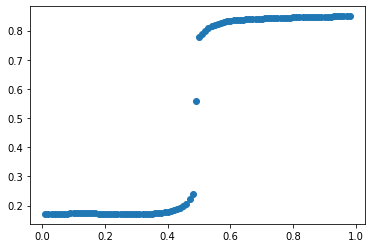

In [16]:
plt.scatter(xj[:,1],yj[:,0])

In [17]:
t1=model.flows[0].T

In [18]:
qt=(t1(torch.zeros(1000,1).uniform_().to(device))).detach().to("cpu")
qs = torch.nn.Softmax(dim=2)(qt).numpy()

In [19]:
qt.shape

torch.Size([1000, 1, 20])

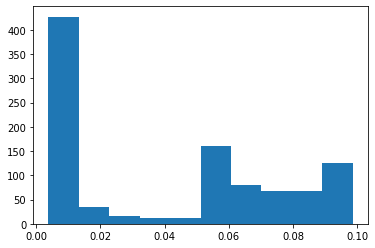

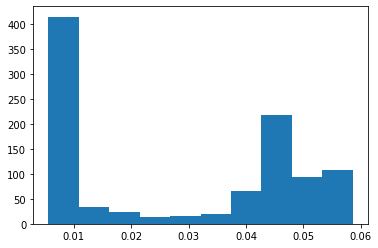

In [20]:
plt.hist(qs[:,:,1])
plt.show()
plt.hist(qs[:,:,0])
plt.show()

(array([427.,  34.,  16.,  11.,  12., 160.,  79.,  68.,  68., 125.]),
 array([0.00377762, 0.01326036, 0.02274311, 0.03222585, 0.04170859,
        0.05119133, 0.06067408, 0.07015682, 0.07963956, 0.0891223 ,
        0.09860504], dtype=float32),
 <a list of 10 Patch objects>)

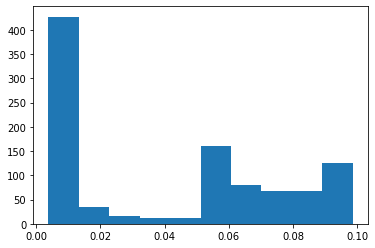

In [21]:
plt.hist(qs[:,:,1])

In [22]:
yj

tensor([[ 0.1716,  0.0112, -1.5281],
        [ 0.1719,  0.0223, -1.5896],
        [ 0.1722,  0.0335, -1.6468],
        [ 0.1724,  0.0447, -1.6995],
        [ 0.1726,  0.0535, -2.1808],
        [ 0.1728,  0.0607, -2.2141],
        [ 0.1729,  0.0678, -2.2446],
        [ 0.1730,  0.0750, -2.2724],
        [ 0.1731,  0.0822, -2.2461],
        [ 0.1732,  0.0898, -2.2696],
        [ 0.1732,  0.0973, -2.2900],
        [ 0.1732,  0.1037, -2.5690],
        [ 0.1732,  0.1096, -2.5808],
        [ 0.1732,  0.1147, -2.8005],
        [ 0.1732,  0.1194, -2.8063],
        [ 0.1731,  0.1242, -2.8106],
        [ 0.1731,  0.1289, -2.8133],
        [ 0.1730,  0.1336, -2.8143],
        [ 0.1729,  0.1383, -2.9127],
        [ 0.1729,  0.1426, -2.9109],
        [ 0.1728,  0.1470, -2.9079],
        [ 0.1727,  0.1510, -3.1523],
        [ 0.1726,  0.1544, -3.1473],
        [ 0.1726,  0.1577, -3.1413],
        [ 0.1725,  0.1611, -3.1343],
        [ 0.1724,  0.1652, -2.9180],
        [ 0.1723,  0.1693, -2.9063],
 